<a href="https://colab.research.google.com/github/kocherlab/naps/blob/main/docs/notebooks/naps_graphics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example NAPS graphics

In this notebook we'll install NAPS, pull the example data from the [GitHub repository](https://github.com/kocherlab/naps), and run `naps-track` against it.

This repo is particularly useful in combination with SLEAP's example notebook on remote training and inference which can be found [here](https://colab.research.google.com/github/talmolab/sleap/blob/main/docs/notebooks/Training_and_inference_on_an_example_dataset.ipynb).

## Install NAPS

In [2]:
# %%capture
# !pip install -q naps-track

In [3]:
# # If you have a model and want to do the inference on Colab, this can be done quite directly! Just upload your model and run inference as below.
# # You can also take advantage of the GPU accessibility of Colab to train as well. Look to the SLEAP tutorials for more info.
# sleap-track example.mp4 -o "example.slp" -m models/bu --verbosity json --batch_size 4 --verbosity json --tracking.tracker simple --tracking.similarity iou --tracker.track_window 5 --tracking.post_connect_single_breaks 1

## Download sample training data into Colab
Let's download a sample dataset from the the NAPS repository.


In [4]:
# %%capture
# !wget https://github.com/kocherlab/naps/raw/main/tests/data/example.slp
# !wget https://github.com/kocherlab/naps/raw/main/tests/data/example.analysis.h5
# !wget https://github.com/kocherlab/naps/raw/main/tests/data/example.mp4

In [5]:
!ls -lht

total 6.1G
-rw-r--r--. 1 swwolf julienlb 224K Aug 16 11:48 naps_graphics.ipynb
drwxr-sr-x. 2 swwolf julienlb  130 Aug 15 15:11 figures
-rw-r--r--. 1 swwolf julienlb 185K Aug 15 12:59 missingness_freq_data.csv
drwxr-sr-x. 2 swwolf julienlb    0 Aug 15 12:58 data
-rw-r--r--. 1 swwolf julienlb 2.2K Aug 10 10:09 aruco_only.py
-rw-rw-r--. 1 swwolf julienlb  63M Aug  9 18:55 output_aruco_1h.npy
-rw-rw-r--. 1 swwolf julienlb  50M Aug  9 17:40 output_2.npy
-rw-r--r--. 1 swwolf julienlb 183K Aug  9 16:16 aruco-example.ipynb
-rw-r--r--. 1 swwolf julienlb 237M Aug  9 13:42 example_1h.analysis.h5
-rw-r--r--. 1 swwolf julienlb 501M Aug  9 13:38 example_1h.slp
-rw-r--r--. 1 swwolf julienlb 4.0G Aug  9 13:37 example_1h.mp4
-rw-r--r--. 1 swwolf julienlb 124M Aug  9 13:36 example_output_1h.analysis.h5
-rw-r--r--. 1 swwolf julienlb  21K Aug  5 13:23 naps_basic_workflow.ipynb
-rw-r--r--. 1 swwolf julienlb 2.0M Aug  3 12:57 example_output.analysis.h5
-rw-r--r--. 1 swwolf julienlb  70M Aug  3 11:27 example

## NAPS tracking
Now let's track the files using `naps-track`. We've adjusted a couple params here to make the tracks nicer.

In [6]:
# !naps-track --slp-path example.slp --h5-path example.analysis.h5 --video-path example.mp4 --tag-node 0 \
#  --start-frame 0 --end-frame 1199 --aruco-marker-set DICT_4X4_100 \
#  --output-path example_output.analysis.h5 --aruco-error-correction-rate 0.6 \
#  --aruco-adaptive-thresh-constant 3 --aruco-adaptive-thresh-win-size-max 50 \
#  --aruco-adaptive-thresh-win-size-step 12 --aruco-perspective-rm-ignored-margin 0.33 \
#  --aruco-adaptive-thresh-win-size-min 3 --half-rolling-window-size 21 

# One liner:
# naps-track --slp-path example_1h_1130to1230pm.slp --h5-path example_1h_1130to1230pm.analysis.h5 --video-path example_1h_1130to1230pm.mp4 --tag-node 0 --start-frame 0 --end-frame 1200 --aruco-marker-set DICT_4X4_100 --output-path example_1h_1130to1230pm_naps.analysis.h5 --aruco-error-correction-rate 0.6 --aruco-adaptive-thresh-constant 7 --aruco-adaptive-thresh-win-size-max 23 --aruco-adaptive-thresh-win-size-step 10 --aruco-perspective-rm-ignored-margin 0.33 --aruco-adaptive-thresh-win-size-min 3 --half-rolling-window-size 21

## After NAPS

In [7]:
"""Read in the h5 and display basic info
"""

import h5py
import numpy as np

filename = "example_output_1h.analysis.h5"
video_filename = "example_1h.mp4"
output_filename = "output_1h.mp4"

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===filename===
example_output_1h.analysis.h5

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(72000, 4, 2, 58)

===nodes===
0: Tag
1: Head
2: Thorax
3: Abdomen



### Utility functions for cleaning up tracks, plotting, and showing the video

In [8]:
"""Resource functions
"""

import pandas as pd
import scipy.ndimage
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.colors as colors
import logging
import skvideo.io
import cv2
import matplotlib.pyplot as plt
import palettable
from IPython.display import HTML
from base64 import b64encode

def flatten_features(x, axis=0):

    if axis != 0:
        # Move time axis to the first dim
        x = np.moveaxis(x, axis, 0)

    # Flatten to 2D.
    initial_shape = x.shape
    x = x.reshape(len(x), -1)

    return x, initial_shape


def unflatten_features(x, initial_shape, axis=0):
    # Reshape.
    x = x.reshape(initial_shape)

    if axis != 0:
        # Move time axis back
        x = np.moveaxis(x, 0, axis)

    return x


def smooth_median(x, window=5, axis=0, inplace=False):
    if axis != 0 or x.ndim > 1:
        if not inplace:
            x = x.copy()

        # Reshape to (time, D)
        x, initial_shape = flatten_features(x, axis=axis)

        # Apply function to each slice
        for i in range(x.shape[1]):
            x[:, i] = smooth_median(x[:, i], window, axis=0)

        # Restore to original shape
        x = unflatten_features(x, initial_shape, axis=axis)
        return x

    y = scipy.signal.medfilt(x.copy(), window)
    y = y.reshape(x.shape)
    mask = np.isnan(y) & (~np.isnan(x))
    y[mask] = x[mask]
    return y


def fill_missing(x, kind="nearest", axis=0, **kwargs):
    """Fill missing values in a timeseries.
    Args:
        x: Timeseries of shape (time, ...) or with time axis specified by axis.
        kind: Type of interpolation to use. Defaults to "nearest".
        axis: Time axis (default: 0).
    Returns:
        Timeseries of the same shape as the input with NaNs filled in.
    Notes:
        This uses pandas.DataFrame.interpolate and accepts the same kwargs.
    """
    if x.ndim > 2:
        # Reshape to (time, D)
        x, initial_shape = flatten_features(x, axis=axis)

        # Interpolate.
        x = fill_missing(x, kind=kind, axis=0, **kwargs)

        # Restore to original shape
        x = unflatten_features(x, initial_shape, axis=axis)

        return x

    return pd.DataFrame(x).interpolate(method=kind, axis=axis, **kwargs).to_numpy()



def plot_trx(
    tracks,
    video_path=None,
    shift=0,
    frame_start=0,
    frame_end=100,
    trail_length=10,
    output_path="output.mp4",
    color_map=None,
    id_map=None,
    scale_factor=1,
    annotate=False,
):
    ffmpeg_writer = skvideo.io.FFmpegWriter(
        f"{output_path}", inputdict={'-r':"20"}, outputdict={"-vcodec": "libx264"}
    )
    if video_path != None:
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_start - 1)
    data = tracks[(frame_start+shift):(frame_end+shift), :, :, :]
    dpi = 300
    for frame_idx in tqdm(range(data.shape[0]), position=0, leave=True):
        fig, ax = plt.subplots(figsize=(1000 / dpi, 1000 / dpi), dpi=dpi)
        plt.gca().invert_yaxis()
        # plt.xlim((0, 3660))
        # plt.ylim((-3660, 0))
        data_subset = data[max((frame_idx - trail_length), 0) : frame_idx, :, :, :]
        for fly_idx in range(data_subset.shape[3]):
            if annotate and data_subset.shape[0] > 0:
                # if  ~(data_subset[-1, 0, 1, fly_idx] < 3660/2):
                plt.annotate(
                    fly_idx,
                    (data_subset[-1, 0, 0, fly_idx], data_subset[-1, 0, 1, fly_idx]),
                    size=18,
                    ha="left",
                    va="bottom",
                    color="#CB9E23",
                )
            for node_idx in range(data_subset.shape[1]):
                for idx in range(2, data_subset.shape[0]):
                    if color_map == None:
                        plt.plot(
                            data_subset[(idx - 2) : idx, node_idx, 0, fly_idx],
                            data_subset[(idx - 2) : idx, node_idx, 1, fly_idx],
                            linewidth= 4.5 * idx / data_subset.shape[0],
                            color=palettable.tableau.Tableau_20.mpl_colors[node_idx],
                        )
                    else:
                        color = color_map[id_map[fly_idx]]
                        (l,) = ax.plot(
                            data_subset[(idx - 2) : idx, node_idx, 0, fly_idx]
                            * scale_factor,
                            data_subset[(idx - 2) : idx, node_idx, 1, fly_idx]
                            * scale_factor,
                            linewidth=3 * idx / data_subset.shape[0],
                            color=color,
                        )
                        l.set_solid_capstyle("round")
        if video_path != None:
            if cap.isOpened():
                res, frame = cap.read()
                frame = frame[:, :, 0]
                plt.imshow(frame, cmap="gray")
        ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
        ax.set_axis_off()
        fig.add_axes(ax)
        fig.set_size_inches(3660 / dpi, 3660 / dpi, True)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis("off")
        fig.patch.set_visible(False)
        fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)
        )
        ffmpeg_writer.writeFrame(image_from_plot)
        plt.close()
    ffmpeg_writer.close()

def instance_node_velocities(fly_node_locations, start_frame, end_frame):
    frame_count = len(range(start_frame, end_frame))
    if len(fly_node_locations.shape) == 4:
        fly_node_velocities = np.zeros(
            (frame_count, fly_node_locations.shape[1], fly_node_locations.shape[3])
        )
        for fly_idx in range(fly_node_locations.shape[3]):
            for n in tqdm(range(0, fly_node_locations.shape[1])):
                fly_node_velocities[:, n, fly_idx] = diff(
                    fly_node_locations[start_frame:end_frame, n, :, fly_idx]
                )
    else:
        fly_node_velocities = np.zeros((frame_count, fly_node_locations.shape[1]))
        for n in tqdm(range(0, fly_node_locations.shape[1] - 1)):
            fly_node_velocities[:, n] = diff(
                fly_node_locations[start_frame:end_frame, n, :]
            )

    return fly_node_velocities


def diff(node_loc, diff_func = np.gradient, **kwargs):
    """
    node_loc is a [frames, 2] arrayF

    win defines the window to smooth over

    poly defines the order of the polynomial
    to fit with

    """
    node_loc_vel = np.zeros_like(node_loc)
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = diff_func(node_loc[:, c], **kwargs)

    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

def show_video(video_path, video_width = 1000):
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [9]:
%%capture

px_mm = 15.5

# Missingness filter
atleast_one_node_defined = np.any(~np.isnan(locations[:, :, 0, :]), axis=1)
no_nodes_defined =  ~atleast_one_node_defined

missing_ct = np.sum(no_nodes_defined, axis=0)
missing_freq = missing_ct / no_nodes_defined.shape[0]
locations_filtered = locations[:, : , :, missing_freq < 0.8]


vel = instance_node_velocities(locations_filtered,0,locations_filtered.shape[0])
mask_2d = ~(vel[:,node_names.index('Thorax'),:] < px_mm*5 )[:,np.newaxis,np.newaxis,:]
mask_4d = np.broadcast_to(mask_2d, locations_filtered.shape)
locations_filtered[mask_4d] = np.nan

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style
import matplotlib as mpl
from matplotlib.patches import Circle
from matplotlib import patches
import sleap

mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = True
mpl.rcParams["font.size"] = 15
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
mpl.rcParams["axes.titlesize"] = "x-large"  # medium, large, x-large, xx-large

mpl.style.use("seaborn-deep")

In [11]:
dset = sleap.load_file("example_1h.slp")
track_occupancy = list(dset.get_track_occupancy(dset.video).values())
track_start_end = [[rangelist.start, rangelist.end] for rangelist in track_occupancy]
track_length =  [rangelist.end- rangelist.start for rangelist in track_occupancy]

frame_rate = 20
data=[ l/frame_rate for l in track_length],


In [12]:
from turtle import title
import h5py
with h5py.File('example_1h.analysis.h5', 'r') as f:
    occupancy_matrix_slp = f['track_occupancy'][:]
    
with h5py.File('/Genomics/ayroleslab2/scott/bees/naps_data/example_1h_1130to1230pm_naps.analysis.h5', 'r') as f:
    occupancy_matrix_naps = f['track_occupancy'][:]
    
missing_freq_slp = np.sum(occupancy_matrix_slp.T == 1,axis=1) / occupancy_matrix_slp.shape[0]
missing_freq_naps = np.sum(occupancy_matrix_naps.T == 1,axis=1) / occupancy_matrix_naps.shape[0]

In [13]:
aruco_only =  np.load("output_aruco_1h.npy")
aruco_only = aruco_only[0:72000,0,0,:]
occupancy_matrix_aruco = ~np.isnan(aruco_only)
missing_freq_aruco = np.sum(occupancy_matrix_aruco.T == 1,axis=1) / occupancy_matrix_aruco.shape[0]
missing_freq_aruco.shape

(57,)

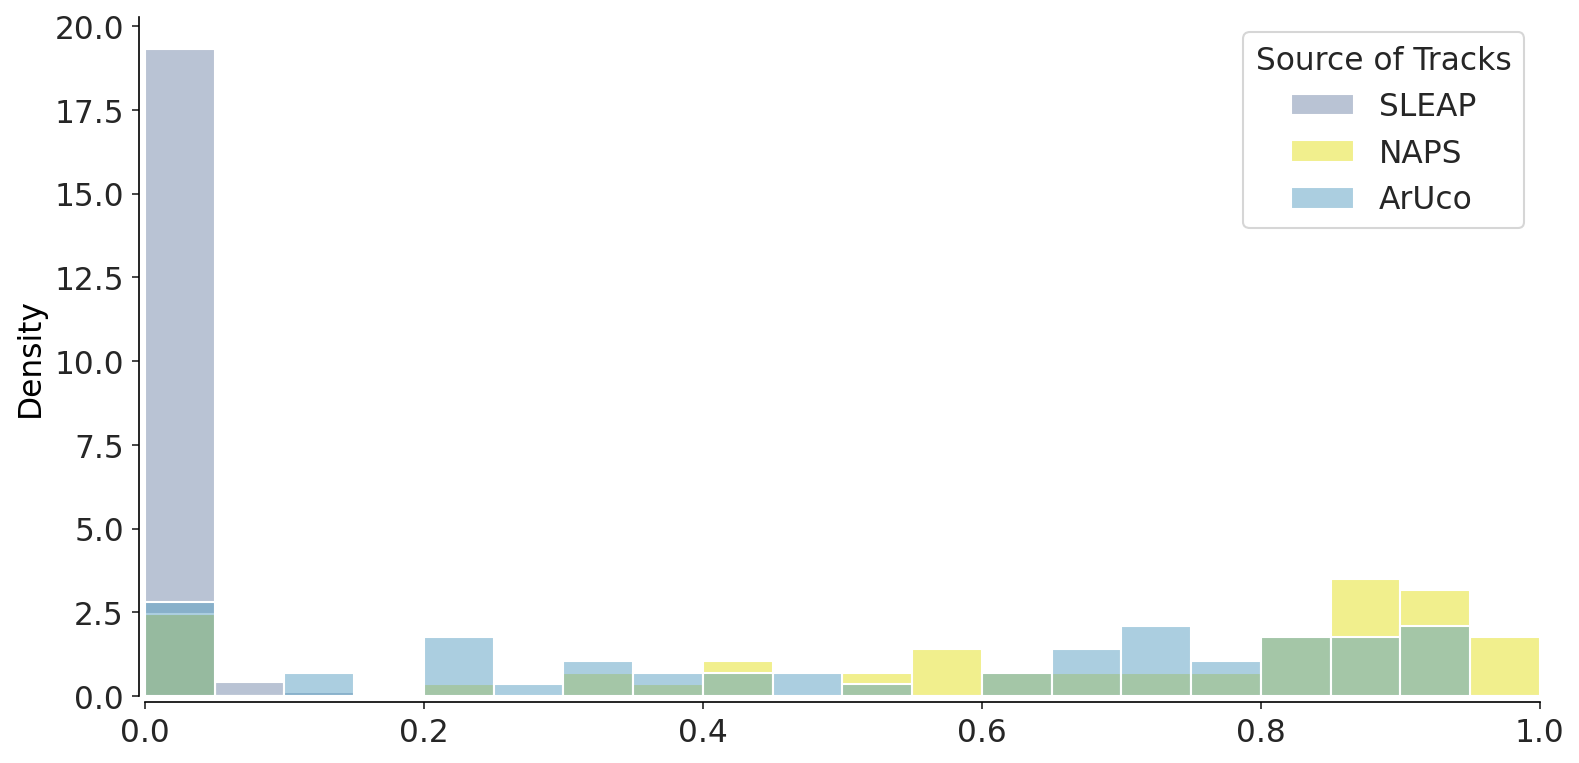

In [14]:
# palette = sns.color_palette(cc.glasbey, n_colors=arr.shape[3])
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# fig.suptitle("Missingness frequency of tracklets")
sns.set_style("ticks")

bins = np.arange(0, 1.01, 0.05)
sns.histplot(
    ax=ax,
    data=missing_freq_slp,
    bins=bins,
    color=palettable.wesanderson.Aquatic2_5.mpl_colors[0],
    legend=False,
    stat="density",
    alpha=0.6
)

sns.histplot(
    ax=ax,
    data=missing_freq_naps,
    bins=bins,
    color=palettable.wesanderson.Aquatic2_5.mpl_colors[1],
    legend=False,
    stat="density",
    alpha=0.6
)
sns.histplot(
    ax=ax,
    data=missing_freq_aruco,
    bins=bins,
    color=palettable.wesanderson.Aquatic2_5.mpl_colors[2],
    legend=False,
    stat="density",
    alpha=0.5
)

plt.xlim(0, 1)
sns.despine(offset=3, trim=False)
plt.legend(labels=["SLEAP", "NAPS", "ArUco"], title = "Source of Tracks")

plt.savefig("figures/track_length_distribution.png", dpi=600)

# TODO: Violin plots SLEAP, NAPS, ARUCO
# Track lengths

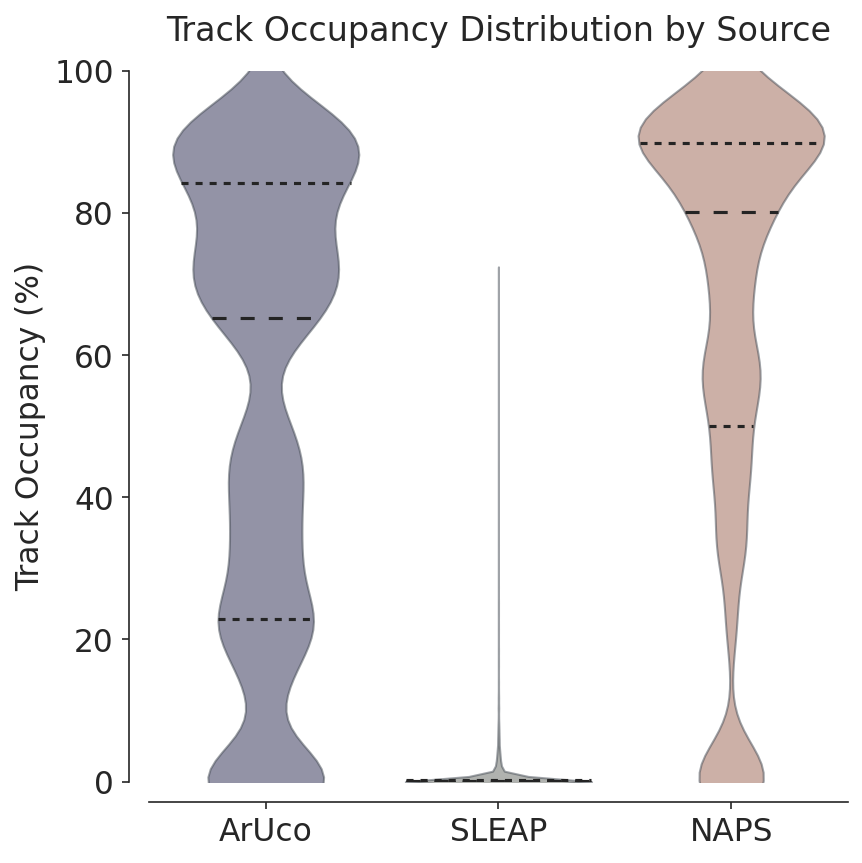

In [26]:
mpl.rcParams["figure.facecolor"] = "w"
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["savefig.dpi"] = 600
mpl.rcParams["savefig.transparent"] = True
mpl.rcParams["font.size"] = 15
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
mpl.rcParams["axes.titlesize"] = "x-large"  # medium, large, x-large, xx-large

mpl.style.use("seaborn-deep")
# palette = sns.color_palette(cc.glasbey, n_colors=arr.shape[3])
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# fig.suptitle("Missingness frequency of tracklets")
sns.set_style("ticks")
import itertools
def patch_violinplot():
     from matplotlib.collections import PolyCollection
     ax = plt.gca()
     for art in ax.get_children():
          if isinstance(art, PolyCollection):
              art.set_edgecolor('#424952')
              art.set_linewidth(1)
              art.set_alpha(0.5)
              
list_of_missing_freqs = [missing_freq_aruco, missing_freq_slp, missing_freq_naps]
data = pd.DataFrame(
    (_ for _ in itertools.zip_longest(*list_of_missing_freqs)),
    columns=["ArUco", "SLEAP", "NAPS"],
)
sns.violinplot(
    ax=ax,
    data=data * 100,
    scale="width",
    inner="quartile",
    bw=0.15,
    palette=palettable.wesanderson.Moonrise7_5.mpl_colors,
    linewidth=1.5,
    
)
patch_violinplot()
# sns.stripplot(data=data*100,ax=ax, color='black', size=2,jitter=0.2, alpha=0.7) 
plt.ylim(0, 100)
sns.despine(offset=10, trim=False)
plt.ylabel("Track Occupancy (%)")
plt.title("Track Occupancy Distribution by Source", fontsize=16, y=1.025)
plt.tight_layout()
plt.savefig("figures/track_length_violin.jpeg", dpi=600)
# plt.legend(labels=["SLEAP", "NAPS", "ArUco"], title = "Source of Tracks", loc="upper center")


In [16]:
data.to_csv("missingness_freq_data.csv")